# Modified 2b

**Goal:** It was challenging for me to get a background estimate with 2b, and the hypothesis was because we feed the PC information into the pairAGraph alg, so this will systematically creat discrepancies between the 2b adn 4b samples.

The goal now is to see if I can derive templates that modify the $D_{b}$ distributions of the pseudo-tagged jets in 2b events.

Since the previous iteration of the resolved analaysis found that the $n_{jets}$ variable had a big impact on the background modelling, I'm going to look into deriving these templates in $n_{jets}$ categories, although I have some posssibilites for what I call $n_{jets}$:
1. The # of jets from the XhhCommon preselection cuts ($p_T$> 25 GeV, $|\eta|$<2.5)
2. The # of jets from the RR cuts ($p_T$> 40 GeV, $|\eta|$<2.5) - this is variable that we use in the reweighting, probably the best motivated!
3. The number of jets fed to pairAGraph. This is a *subset* of the RR jets, can be 4 or 5.

However, I don't think option 1 is paricularly well motivated, so I'll just try out options 1 and 2.

I think there's also the option of how we use these histograms to derive PCs, like I think we might want to subtract off the 2b histogram.

These templates will be derived in the CR and I'll evaluate them in the VR.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import uproot
import os
import json

%load_ext autoreload
%autoreload 2

In [2]:
nSelectedJets = 5

sigSubDir = 'SMNR_mc16a_PFlow-AUG2019'
bkgSubDir = 'data_16_PFlow-MAY2019'

if nSelectedJets != 4:
    sigSubDir += f'-{nSelectedJets}jets'
    bkgSubDir += f'-{nSelectedJets}jets'

In [3]:
sFile = f"../data/{sigSubDir}/test_df_f_0.22_3b_scaledInputs_withCuts.h5"
sig_df = pd.read_hdf(sFile, key='df')

bFile = f"../data/{bkgSubDir}/df_f_0.22_NNT_HCs.h5"
bkg_df = pd.read_hdf(bFile,key='df')

# Apply the cuts up to Xwt
bkg_df['deta_hh'] = np.abs(bkg_df.eta_h1-bkg_df.eta_h2)
bkg_df['cut_deta_hh'] = (bkg_df.deta_hh < 1.5) #& (bkg_df.MDpT)
bkg_df['cut_Xwt'] = (bkg_df.X_wt > 1.5) #& (bkg_df.cut_deta_hh)


In [4]:
CR = (bkg_df.kinematic_region == 2)
VR = (bkg_df.kinematic_region == 1)
SR = (bkg_df.kinematic_region == 1)

In [5]:
dataText = "$\mathbf{ATLAS}$ data Internal\n"
dataText += "2016 data MAY2019 prod\n"
dataText += "MV2c10 70% WP with pairAGraph"

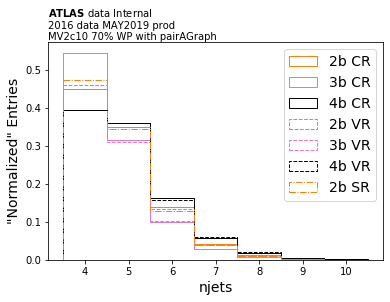

In [6]:
for r, region,ls in zip([2,1,0],['CR','VR','SR'],['-','--','-.']):

    plt.hist(bkg_df.loc[(bkg_df.ntag==2)&(bkg_df.kinematic_region == r),'njets'],
             7,(3.5,10.5),
             histtype='step',color='C1',linestyle=ls,label=f'2b {region}',density=True)

    if r==0:
        continue
    
    plt.hist(bkg_df.loc[(bkg_df.ntag==3)&(bkg_df.kinematic_region == r),'njets'],
             7,(3.5,10.5),
             histtype='step',color='C6',linestyle=ls,label=f'3b {region}',density=True)

    plt.hist(bkg_df.loc[(bkg_df.ntag>=4)&(bkg_df.kinematic_region == r),'njets'],
             7,(3.5,10.5),
             histtype='step',color='k',linestyle=ls,label=f'4b {region}',density=True)

plt.xlabel('njets',fontsize=14)
plt.ylabel('"Normalized" Entries',fontsize=14)
plt.legend(fontsize=14)

ax = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/njets_234b_CVSR.pdf',bbox_inches='tight')

plt.show()

**Question:** Why isn't there a smoothly varying trend from 4b, 3b, 2b?

Should I make this a ratio plot?

I'd need to think about what I would want to demonstrate though!

Note - maybe I *don't* actually want 2b on this plot, just 3b and 4b? 
(B/c the 2b sample is what I'm trying to change with this defintion, modifying the inputs will modify the massplane, which will modify these regions.)

Maybe a message of this plot is you can see that 2b is showing the most discrepancies b/w the regions while the 3b and 4b kinematics look more constant?

**Remember** I also didn't train on 2b!!!!

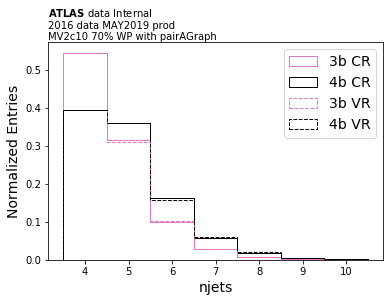

In [7]:
for r, region,ls in zip([2,1],['CR','VR'],['-','--']):


    plt.hist(bkg_df.loc[(bkg_df.ntag==3)&(bkg_df.kinematic_region == r),'njets'],
             7,(3.5,10.5),
             histtype='step',color='C6',linestyle=ls,label=f'3b {region}',density=True)

    plt.hist(bkg_df.loc[(bkg_df.ntag>=4)&(bkg_df.kinematic_region == r),'njets'],
             7,(3.5,10.5),
             histtype='step',color='k',linestyle=ls,label=f'4b {region}',density=True)

plt.xlabel('njets',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.legend(fontsize=14)

ax = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/njets_34b_CVR.pdf',bbox_inches='tight')

plt.show()

If the bins have width 1, then the density option in plt.hist is doing the same thing as root.

Ok, my take away message from this plot is that the shape of this variable in the CR is a good model for the VR, and ergo will hopefully also be indicative of the SR!

(I could make a ratio plot of VR / CR for each of the b-tag categories...)


**Next:** Plot the PC scores in each of these `njets` bins.

In [8]:
bkg_df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'HT', 'MDR',
       'MDpT', 'cut_deta_hh', 'cut_Xwt', 'deta_hh'],
      dtype='object')

Ok, I didn't save enough useful info with this dataframe to make the plot of interest... I'll need to load in the some other low level dfs! (See

In [9]:
reload=True

In [10]:
tag = '_mlJetInputs'
fDir = f"../data/{bkgSubDir}/"
fout = f"{fDir}df_f_0.22{tag}.h5"

periods = ['A','B','C','D','E','F','G','H','I','J','K','L']

if reload:
    dfs = []

    for period in periods:

        print('period',period)
        fName = f"files/df_period{period}_f_0.22{tag}.h5"

        if os.path.exists(fDir+fName):
            dfi = pd.read_hdf(fDir+fName,key='df')
            dfs.append(dfi)
        else:
            print(fDir+fName)

    df = pd.concat(dfs,ignore_index=True)
    df.to_hdf(fout,key='df',mode='w')
    
else:
    df = pd.read_hdf(fout,key='df')

period A
period B
period C
period D
period E
period F
period G
period H
../data/data_16_PFlow-MAY2019-5jets/files/df_periodH_f_0.22_mlJetInputs.h5
period I
period J
../data/data_16_PFlow-MAY2019-5jets/files/df_periodJ_f_0.22_mlJetInputs.h5
period K
period L


In [11]:
df.head()

run_number  event_number  mc_sf  ntag  njets  kinematic_region        m_hh  \
0      298609       4238123      1     3    4.0                -1  813.706916   
1      298609       3840953      1     3    6.0                -1  310.964570   
2      298609       3558172      1     1    4.0                -1  535.070163   
3      298609       5425711      1     2    4.0                 2  385.289116   
4      298609       6145057      1     3    6.0                -1  714.077979   

        pt_hh      X_wt    m_hh_cor  ...   ml_j4_E  ml_j0_Db  ml_j1_Db  \
0   20.928099  6.691344  948.862363  ...  0.000000       2.5       2.5   
1   99.894391  2.994519  428.502949  ... -1.569858       2.5       2.5   
2  127.016966  2.561435  491.570482  ...  0.000000       2.5       0.5   
3   17.175302  3.725297  365.228218  ...  0.000000       2.5       2.5   
4  117.401132  4.495913  640.855832  ... -1.892910       2.5       2.5   

   ml_j2_Db  ml_j3_Db  ml_j4_Db  idx_HC0_j0  idx_HC0_j1  idx_HC1_j0  \
0       1.5       0.5       0.0           2           0           1   
1       1.5      -1.5      -1.5           2           4           1   
2      -1.5      -1.5       0.0           0           3           1   
3      -1.5      -1.5       0.0           0           1           2   
4       2.5      -1.5      -1.5           1           0           2   

   idx_HC1_j1  
0           3  
1           0  
2           2  
3           3  
4           3  

[5 rows x 64 columns]

In [12]:
Db_cols = [f'ml_j{ji}_Db' for ji in range(nSelectedJets)]

In [13]:
from preprocess import jetVars

The way we shaped the data for the input for pairAGraph was (nEvents, nJets, nVariables)

In [14]:
jet_cols = [f'ml_j{ji}_{v}' for ji in range(nSelectedJets) for v in jetVars]

In [15]:
jetInputs = df[jet_cols].values.reshape(-1,nSelectedJets,len(jetVars))
jetInputs[0]

array([[-0.96442479,  2.24142218,  0.94351411,  0.69400996,  2.5       ],
       [ 1.17989671,  1.31605339, -1.68571901,  1.39595687,  2.5       ],
       [ 1.31912434,  2.31701159,  1.45291901,  2.79344344,  1.5       ],
       [-0.88093454,  2.15775132, -2.00338173,  0.65713519,  0.5       ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [16]:
jetMask = ~np.all(jetInputs==0,axis=-1)

In [17]:
njetsRange = np.arange(4,9).astype(int)
njetsRange

array([4, 5, 6, 7, 8])

**How to get these templates correctly**

I just need to pseudo-tag 2 of the jets in the 2b sample, so the logic below takes care of that, which I need to consider separately depending on how many jets are going into these histograms.

4 2.5 6.0
5 1.0 6.0
6 1.0 6.0
7 1.0 6.0
8 1.0 5.0


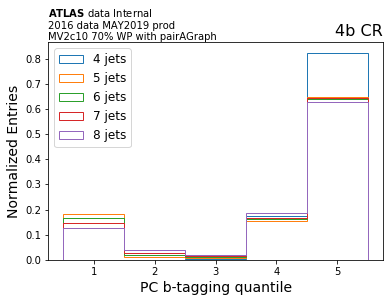

In [18]:
Db_4b = {}

for nj in njetsRange:
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    
    evtMask = (df.kinematic_region==2) & njmask & (df.ntag >= 4)
    
    # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
    Db = jetInputs[evtMask,:,-1]+2.5
    print(nj,np.min(Db),np.max(Db))
    
    # I need the jet mask to avoid plotting the *masked* values
    n,_,_ = plt.hist(Db[jetMask[evtMask]], 5,(0.5,5.5),density=True,
                     label=f'{nj} jets',histtype='step')
    
    if nj >= 5:
        w1 = np.sum(n[:3])
        w2 = np.sum(n[-2:])

        n = np.concatenate((n[:3]/w1, 2*n[-2:]/w2))/3
        
    # Save the PT template
    Db_4b[int(nj)] = list(n) 

plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.title('4b CR',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(loc='upper left',fontsize=12)
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_4b_CR.pdf',bbox_inches='tight')

plt.show()

# Write to a .json file 
filename = "Db_njets_4b_CR.json"
with open(filename, 'w') as varfile:
    json.dump(Db_4b, varfile)


At first I was confused if I wanted to subtract the 2b histogram from the 4b histogram, so the plots below are just demonstrating that the PC templates tend to be the same so matter *what* region of the massplane you're in.

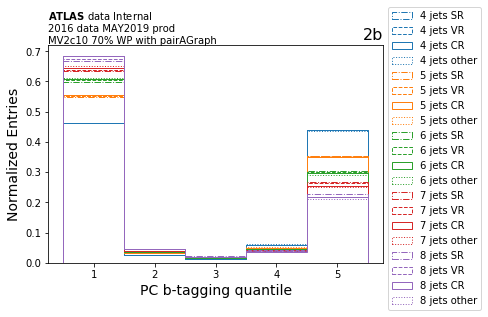

In [19]:
for i,nj in enumerate(njetsRange):
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    for r, region,ls in zip([0,1,2,-1],['SR','VR','CR','other'],['-.','--','-','dotted']):
        evtMask = (df.kinematic_region==r) & njmask & (df.ntag == 2)

        # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
        Db = jetInputs[evtMask,:,-1]+2.5
        
        # I need the jet mask to avoid plotting the *masked* values
        n,_,_ = plt.hist(Db[jetMask[evtMask]], 5,(0.5,5.5),density=True,
                         color=f'C{i}',linestyle=ls,
                         label=f'{nj} jets {region}',histtype='step')
        
plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.title('2b',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(bbox_to_anchor=(1,1.2))
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_2b_fullmassplane.pdf',bbox_inches='tight')

plt.show()


Just to sanity check things, make the same plot for 4b (just to make sure that you're not crazy, lol)

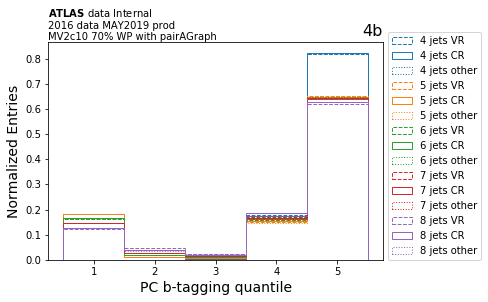

In [20]:
for i,nj in enumerate(njetsRange):
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    for r, region,ls in zip([1,2,-1],['VR','CR','other'],['--','-','dotted']):
        evtMask = (df.kinematic_region==r) & njmask & (df.ntag >= 4)

        # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
        Db = jetInputs[evtMask,:,-1]+2.5
        
        # I need the jet mask to avoid plotting the *masked* values
        n,_,_ = plt.hist(Db[jetMask[evtMask]], 5,(0.5,5.5),density=True,
                         color=f'C{i}',linestyle=ls,
                         label=f'{nj} jets {region}',histtype='step')
        
plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.title('4b',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(bbox_to_anchor=(1,1.07))
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_4b_notSR.pdf',bbox_inches='tight')

plt.show()


Ok, these two plots make me feel pretty comfortable about my methodology moving forward!

In [21]:
np.min(jetInputs[:,:,-1]),np.max(jetInputs[:,:,-1])

(-1.5, 3.5)

In [22]:
wierd = np.any(jetInputs[:,:,-1]==3.5,axis=-1)
np.sum(wierd)

11559

Ok, since this *almost* never happens, I think it's coming from overflow in the `np.digitize` function when the MV2 value is actually 1. I can fix this by having np.digitize add $\epsilon = 10^{-8}$, but I doubt this will matter for the purpose of this study.

4 1.0 6.0
5 1.0 6.0
6 1.0 6.0
7 1.0 6.0
8 1.0 6.0


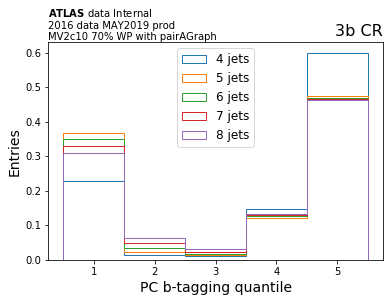

In [23]:
for nj in njetsRange:
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    evtMask = (df.kinematic_region==2) & njmask & (df.ntag == 3)
    
    Db = jetInputs[evtMask,:,-1]+2.5
    print(nj,np.min(Db),np.max(Db))
    
    plt.hist(Db[jetMask[evtMask]], 5,(0.5,5.5),density=True,
             label=f'{nj} jets',histtype='step')

plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.title('3b CR',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(loc='upper center',fontsize=12)
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_3b_CR.pdf',bbox_inches='tight')

plt.show()

Also check the extrapolation of these templates into the VR!

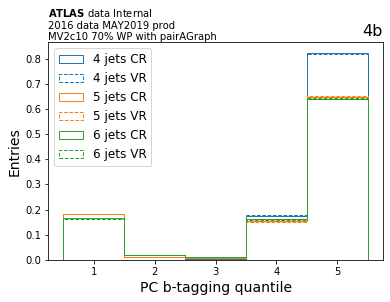

In [24]:
for i,nj in enumerate([4,5,6]):
     
        
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    for r, region,ls in zip([2,1],['CR','VR'],['-','--']):
        evtMask = (df.kinematic_region==r) & njmask & (df.ntag >= 4)

        # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
        Db = jetInputs[evtMask,:,-1]+2.5

        # I could avoid the mask since I don't plot these 0 entries anyways
        plt.hist(Db[jetMask[evtMask]], 5,(0.5,5.5),color=f'C{i}',density=True,
                 label=f'{nj} jets {region}',histtype='step',linestyle=ls)

plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.title('4b',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(loc='upper left',fontsize=12)
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_4b_CR+VR.pdf',bbox_inches='tight')

plt.show()

Ok, so you extrapolate into the VR, the jets are more likely to be in a higher quantile.

*I'm not sure how to tell if this is a problem or not, or if this level of discrepancy is ok*

**Thoughts**
- It's better than what I had before
- We do still have a full event level kinematic reweighting, so this is a reasonable thing to test out!
- I think the discrepancy here *does* translate into a systematic uncertainty though.

Ok, the notes above were when I was looking at just period A where the stats were lower. 
This figure looks pretty good when I'm looking at all the 4b data in 2016.

Ok, this looks cool! In the meantime, I'm going to plot the other jet variables as well to gain some intuition.

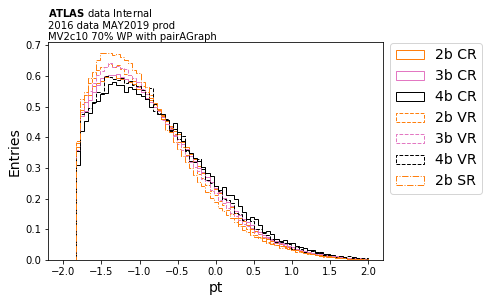

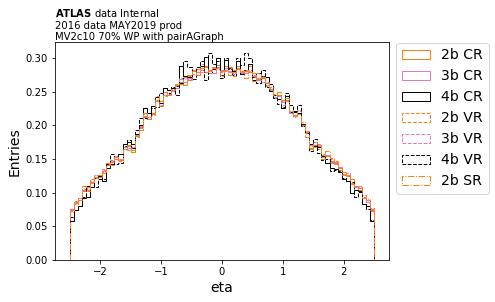

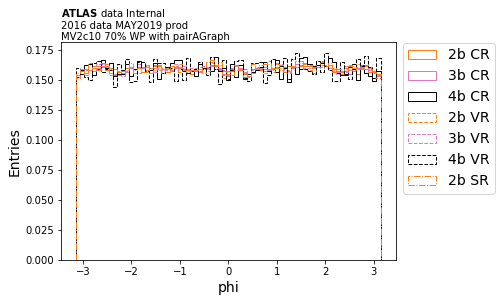

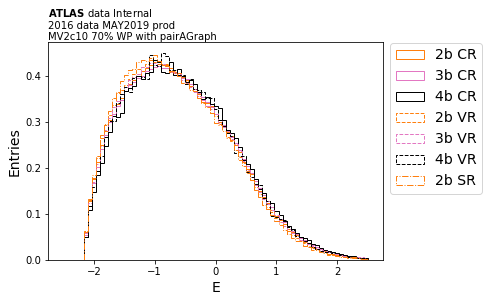

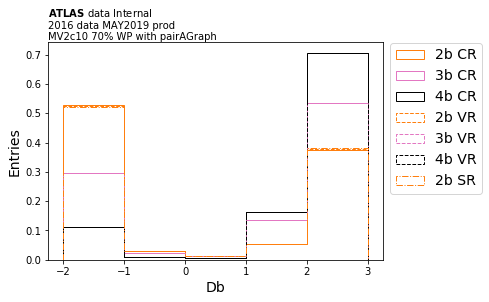

In [25]:
for i,v,n,myRange in zip(range(5), jetVars, [75]*4+[5], [(-2,2),(-2.5,2.5),(-np.pi,np.pi),(-2.5,2.5),(-2,3)]):
    
    for r, region,ls in zip([2,1,0],['CR','VR','SR'],['-','--','-.']):

        for nb,color in zip([2,3,4],['C1','C6','k']):
            
            if (r==0) & (nb >= 3):
                continue
            
            if nb == 4:
                evtMask = (df.kinematic_region==r) & (df.ntag>=4)
            else:
                evtMask = (df.kinematic_region==r) & (df.ntag==nb)
    
            # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
            x = jetInputs[evtMask,:,i]

            plt.hist(x[jetMask[evtMask]], n,myRange, label=f'{nb}b {region}',
                     histtype='step',color=color,linestyle=ls,density=True)

    plt.xlabel(v,fontsize=14)
    plt.ylabel('Entries',fontsize=14)
    ax = plt.gca()

    plt.legend(bbox_to_anchor=(1,1.03),fontsize=14)
    plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

    plt.savefig(f'figures/{bkgSubDir}/ml_{v}_234b_CVSR.pdf',bbox_inches='tight')
    
    plt.show()

Ok, the variable with the biggest discrepancy is *clearly* $D_b$, although there are noticable biases in the $p_T$ as well.

It seems like the most useful feature of the $p_T$ spectrum is that 2b is softer, but that's kind of like a "duh yeah" comment.

*Perhaps a useful follow-up step would be to do a Db tag that also depends on the jet $p_T$, so like a reweighting in 2d?*


Would it be useful to overlay the signal on these plots?

Either I :
1. Didn't log xform $p_T$ before scaling
2. I should be subtracting 40 before taking the log

No, I think it looks ok, the background kinematics is just softer than the signal kinematics.

**Modify the 2b data**

- I think I can just use the `Db_4b` dictionary, but for putting this logic in the `preprocess.py` I'll need to load in the scaling file.

**Plan:** Save to `new_ml_jet{i}_Db`, although in the `transformData` function, I'll rewrite the `ml_jet{i}_Db` column, and just save the `jet{i}_Db` column for reference for what the 2b quantiles looked like before.


In [26]:
Db_cols

['ml_j0_Db', 'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db']

In [27]:
new_Db_cols = [f'new_{c}' for c in Db_cols]

for i in range(nSelectedJets):
    
    c = f'new_ml_j{i}_Db'
    if i < 2:
        df[c] = df[f'ml_j{i}_Db']
    else:
        df[c] = 0
    

In [28]:
evtMask

0          False
1          False
2          False
3          False
4          False
           ...  
7496806    False
7496807    False
7496808    False
7496809    False
7496810    False
Length: 7496811, dtype: bool

In [29]:
df['GNNjets'] = np.sum(jetMask,axis=-1)

In [30]:
for nj in njetsRange:
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    evtMask = njmask & (df.ntag == 2)

    for stop in range(4,nSelectedJets+1):

        N = np.sum(evtMask & (df.GNNjets==stop))
        
        for c in new_Db_cols[2:stop]:
            df.loc[evtMask & (df.GNNjets==stop),c] = np.random.choice(np.arange(-1.5,3.5), N, p=Db_4b[nj])


[0.         0.         0.00243774 0.1473483  0.85021395]
[0.1817054  0.0171782  0.19382252 0.09557051 0.51172338]
[0.21508609 0.03011093 0.18324554 0.09724573 0.47431171]
[0.2328345  0.04317139 0.17504599 0.09732699 0.45162111]
[0.247848   0.05953827 0.16152186 0.10619787 0.424894  ]


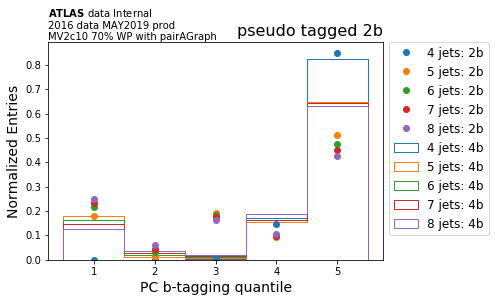

In [31]:
for i,nj in enumerate(njetsRange):
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    
    mask_4b = (df.kinematic_region==2) & njmask & (df.ntag >= 4)
    mask_2b = njmask & (df.ntag == 2)
    
    
    # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
    Db = jetInputs[mask_4b,:,-1]+2.5
    
    # I need the jet mask to avoid plotting the *masked* values
    n,_,_ = plt.hist(Db[jetMask[mask_4b]], 5,(0.5,5.5),density=True,
                     label=f'{nj} jets: 4b',histtype='step')
    

    n_2b,_ = np.histogram(df.loc[mask_2b,new_Db_cols[:nj]].values+2.5,
                          5,(0.5,5.5),density=True)
    print(n_2b)
    plt.plot(np.arange(1,6),n_2b,color=f'C{i}',marker='o',
             linewidth=0, label=f'{nj} jets: 2b')
    
plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.title('pseudo tagged 2b',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(bbox_to_anchor=(1,1.03),fontsize=12)
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/{bkgSubDir}/Db_njets_4b_CR_2b_PT.pdf',bbox_inches='tight')

plt.show()


[0.         0.         0.00199779 0.12247036 0.87553186]
[0.13964747 0.02477653 0.01344719 0.10580772 0.71632108]
[0.23132339 0.04187906 0.02103738 0.09600425 0.60975591]
[0.29477177 0.05458017 0.02738967 0.09088436 0.53237403]
[0.352678   0.06769992 0.03393329 0.08627541 0.45941338]


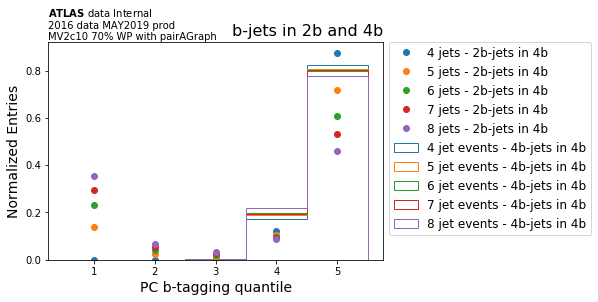

In [32]:
for i,nj in enumerate(njetsRange):
     
    if nj == njetsRange[-1]:
        njmask = (df.njets >= nj)
    else:
        njmask = (df.njets == nj)
    
    
    mask_4b = (df.kinematic_region==2) & njmask & (df.ntag >= 4)
    mask_2b = njmask & (df.ntag == 2)
    
    
    # I will also need a mask for the jets in the event, similar to how I made masks for the tracks
    Db = jetInputs[mask_4b,:4,-1]+2.5
    
    # I need the jet mask to avoid plotting the *masked* values
    n,_,_ = plt.hist(Db[jetMask[mask_4b,:4]], 5,(0.5,5.5),density=True,
                     label=f'{nj} jet events - 4b-jets in 4b',histtype='step')
    

    n_2b,_ = np.histogram(jetInputs[mask_2b,:2,-1]+2.5,
                          5,(0.5,5.5),density=True)
    print(n_2b)
    plt.plot(np.arange(1,6),n_2b,color=f'C{i}',marker='o',
             linewidth=0, label=f'{nj} jets - 2b-jets in 4b')
    
plt.xlabel('PC b-tagging quantile',fontsize=14)
plt.ylabel('Normalized Entries',fontsize=14)
plt.title('b-jets in 2b and 4b',loc='right',fontsize=16)
ax = plt.gca()

plt.legend(bbox_to_anchor=(1,1.03),fontsize=12)
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

#plt.savefig(f'figures/{bkgSubDir}/Db_njets_4b_CR_2b_PT.pdf',bbox_inches='tight')

plt.show()


In [33]:
jetInputs[mask_2b,:2,-1].shape

(39015, 2)

Something seems *fucked* atm, all of these jets *should* have been in Q4 and Q5 (for 70% WP 2b).

Maybe the jets are sorted by $p_T$ and not $D_b$?

In [34]:
jetInputs[mask_2b,:,-1]+2.5

array([[4. , 1. , 1. , 1. , 1. ],
       [5. , 1. , 1. , 1. , 2.5],
       [5. , 5. , 1. , 1. , 1. ],
       ...,
       [5. , 1. , 1. , 1. , 1. ],
       [5. , 1. , 1. , 1. , 2.5],
       [5. , 1. , 1. , 1. , 2.5]])

In [35]:
jetInputs[mask_4b,:,-1]+2.5

array([[5., 5., 5., 4., 2.],
       [5., 5., 5., 5., 2.],
       [5., 5., 5., 4., 2.],
       ...,
       [5., 5., 4., 4., 1.],
       [5., 5., 5., 5., 4.],
       [5., 5., 5., 5., 5.]])

Ok, but I think this plot is demonstrating pretty clearly that the issue w/ the 2b sample I've made is *not* with the templates that I've made, it seems to be with the underlying 2b distribuion.
- Check my edges for MV2c10
- I could also try to calculate some signal efficiencies with these edges?

In [36]:
sum([0.27890654, 0.06815653, 0.03483192, 0.12595167, 0.49215333])

0.9999999900000001

Ok, interesting - this is quite a bit worse than I was expecting it would be, but it's sitll better than it would have been for 2b (I guess) 

Worth implementing and trying out the background estimate!!

I think a nice way to sanity check this method is to overlay histograms for the 4b CR with the 2b fullmassplane!

Ok, after I've played w/ the syntax, I think I should 
- Copy it over to the `getHCs` function in the `preprocess.py` module
- Test running over period A
- Submit all the jobs
- Check the massplane
- Try to get a background estimate

In [37]:
tag = '_PT_2b'
fDir = f"../data/{bkgSubDir}/"
fout = f"{fDir}df_f_0.22{tag}.h5"

periods = ['A','B','C','D','E','F','G','H','I','J','K','L']

if reload:
    dfs = []

    for period in periods:

        print('period',period)
        fName = f"files/df_period{period}_f_0.22{tag}.h5"

        if os.path.exists(fDir+fName):
            dfi = pd.read_hdf(fDir+fName,key='df')
            dfi['period'] = period
            dfs.append(dfi)
        else:
            print(fDir+fName)

    df_pt = pd.concat(dfs,ignore_index=True)
    df_pt.to_hdf(fout,key='df',mode='w')
    
else:
    df_pt = pd.read_hdf(fout,key='df')

period A
period B
period C
period D
period E
period F
period G
period H
../data/data_16_PFlow-MAY2019-5jets/files/df_periodH_f_0.22_PT_2b.h5
period I
period J
../data/data_16_PFlow-MAY2019-5jets/files/df_periodJ_f_0.22_PT_2b.h5
period K
period L


Look at the massplanes

In [38]:
os.sys.path.append('../eda_tools')
from plot_helper import massplane

In [39]:
df_pt.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'HT', 'MDR',
       'MDpT', 'cut_deta_hh', 'cut_Xwt', 'pred_pair', 'GNNjets', 'ml_j0_pt',
       'ml_j1_pt', 'ml_j2_pt', 'ml_j3_pt', 'ml_j4_pt', 'ml_j0_eta',
       'ml_j1_eta', 'ml_j2_eta', 'ml_j3_eta', 'ml_j4_eta', 'ml_j0_phi',
       'ml_j1_phi', 'ml_j2_phi', 'ml_j3_phi', 'ml_j4_phi', 'ml_j0_E',
       'ml_j1_E', 'ml_j2_E', 'ml_j3_E', 'ml_j4_E', 'ml_j0_Db', 'ml_j1_Db',
       'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db', 'j0_pt', 'j1_pt', 'j2_pt', 'j3_pt',
       'j4_pt', 'j0_eta', 'j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j0_phi',
       'j1_phi', 'j2_phi', 'j3_phi', 'j4_phi', 'j0_E', 'j1_E', 'j2_E', 'j3_E',
       'j4_E', 'j0_Db', 'j1_Db', 'j2_Db', 'j3

In [40]:
df_pt['deta_hh'] = np.abs(df_pt.eta_h1 - df_pt.eta_h2)
df_pt['cut_deta_hh'] = (df_pt['deta_hh'] < 1.5)
df_pt['cut_Xwt'] = (df_pt['X_wt'] > 1.5)

In [41]:
(df_pt.ntag==2)

0          False
1          False
2          False
3           True
4          False
           ...  
7496806    False
7496807    False
7496808    False
7496809    False
7496810     True
Name: ntag, Length: 7496811, dtype: bool

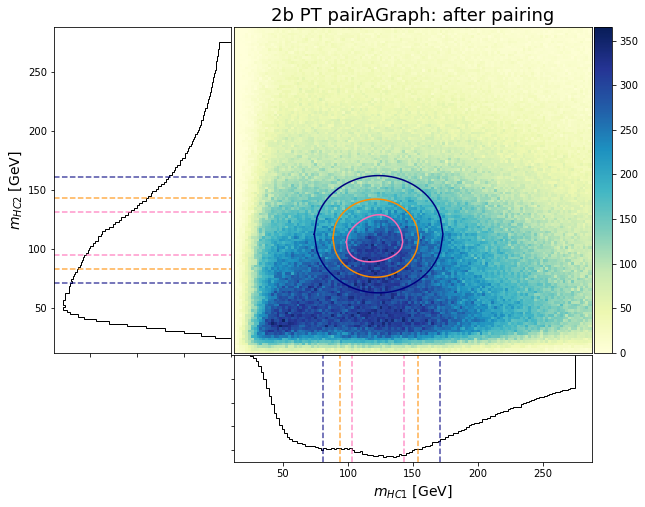

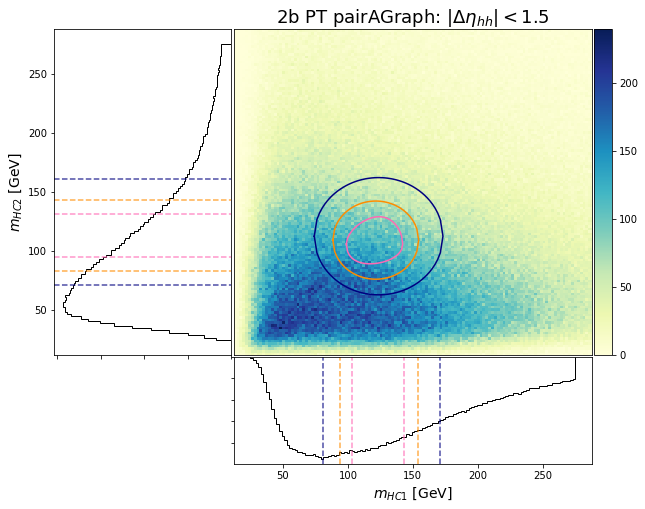

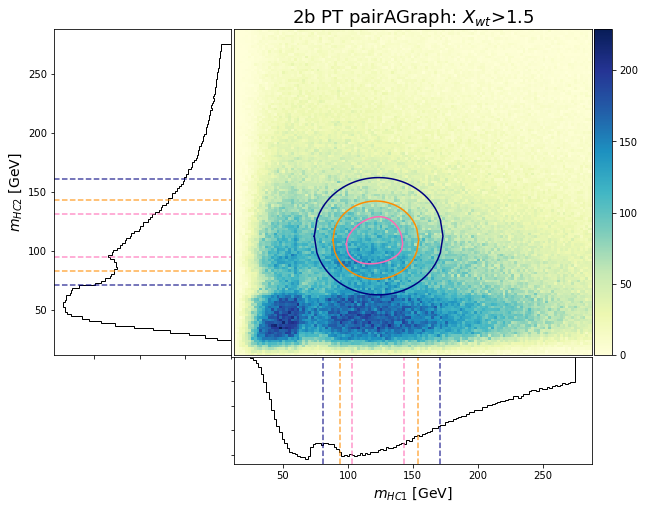

In [42]:
kwargs = {'figsize': (10, 8),
           'bins' : (125, 125),
           'xrange': (25, 275),
           'yrange': (25, 275),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'YlGnBu',
           'title': 'pairAGraph: just pairing',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           'filename': f'{fDir}/{bkgSubDir}/massplane_4jetsGNN_2b.pdf',
           'alpha': 0.7,
           'save': False,
           'show': True
          }

mask = np.ones_like(df_pt.index).astype(bool)

masks = [(df_pt.ntag==2), df_pt.cut_deta_hh, df_pt.cut_Xwt ]

title = '2b PT pairAGraph: '

for m,ID in zip(masks,['after pairing', '$|\Delta \eta_{hh}| < 1.5$', '$X_{wt}$>1.5']):
    
    mask = mask & m
    
    # Modify the title and figure name
    kwargs['title'] = title+ID
    
    fig = massplane(df_pt.loc[mask,'m_h1'],
                    df_pt.loc[mask,'m_h2'],**kwargs)

    fig.show()

I already calculated the 3b and 4b masks in another nb, and since nothing changed w/r.t. that, no need to recalculate them here!

Recheck the 2b cutflow $m_{hh}$ plot

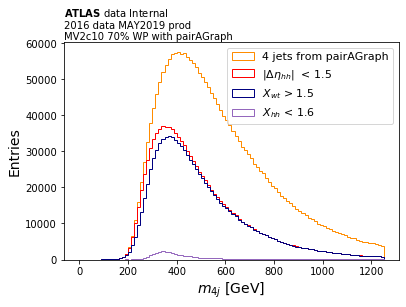

In [43]:
density=False

plt.hist(df_pt.loc[df_pt.ntag==2,'m_hh'],100,(0,1250),histtype='step',label='4 jets from pairAGraph',
         color='darkorange',density=density)
# plt.hist(df_pt.loc[(df_pt.ntag==2)&(df_pt.MDR),'m_hh'],100,(0,1250),histtype='step',label='MDR',
#          color='cornflowerblue',density=density)
# plt.hist(df_pt.loc[(df_pt.ntag==2)&df_pt.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
#          color='green',density=density)
plt.hist(df_pt.loc[(df_pt.ntag==2)&df_pt.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         color='red',density=density)
plt.hist(df_pt.loc[(df_pt.ntag==2)&df_pt.cut_deta_hh&df_pt.cut_Xwt,'m_hh'],100,(0,1250),histtype='step',label='$X_{wt}$ > 1.5',
         color='navy',density=density)
plt.hist(df.loc[(df_pt.ntag==2)&df_pt.cut_deta_hh&df_pt.cut_Xwt & (df_pt.kinematic_region==0),'m_hh'],100,(0,1250),histtype='step',label='$X_{hh}$ < 1.6',
         color='C4',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend(fontsize=11)

ax = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

#plt.savefig(f'{figDir}/m4j_allCuts.pdf',bbox_inches='tight')

plt.show()


In [44]:
df_pt.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'HT', 'MDR',
       'MDpT', 'cut_deta_hh', 'cut_Xwt', 'pred_pair', 'GNNjets', 'ml_j0_pt',
       'ml_j1_pt', 'ml_j2_pt', 'ml_j3_pt', 'ml_j4_pt', 'ml_j0_eta',
       'ml_j1_eta', 'ml_j2_eta', 'ml_j3_eta', 'ml_j4_eta', 'ml_j0_phi',
       'ml_j1_phi', 'ml_j2_phi', 'ml_j3_phi', 'ml_j4_phi', 'ml_j0_E',
       'ml_j1_E', 'ml_j2_E', 'ml_j3_E', 'ml_j4_E', 'ml_j0_Db', 'ml_j1_Db',
       'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db', 'j0_pt', 'j1_pt', 'j2_pt', 'j3_pt',
       'j4_pt', 'j0_eta', 'j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j0_phi',
       'j1_phi', 'j2_phi', 'j3_phi', 'j4_phi', 'j0_E', 'j1_E', 'j2_E', 'j3_E',
       'j4_E', 'j0_Db', 'j1_Db', 'j2_Db', 'j3

In [45]:
from NN_RW import getNNweights

Using TensorFlow backend.


In [46]:
modelName = f"NN_rw/{bkgSubDir}/xformer_train_SMNR_mc16ade/afterPairing_PT_2b.h5"

X_all = getNNweights(df_pt, kinematic_region=2,epochs = 50, patience=10,
             train=False, key="w_2b_afterPairing",modelName=modelName)

Instructions for updating:
Colocations handled automatically by placer.


I *have* a background estimate now!!

So now I just need to 
1. Evaluate it - and -
2. Get the limits

In [59]:
rw_vars = ['njets','pT_4', 'pT_2', 'dRjj_1', 'dRjj_2','eta_i','pt_hh','m_hh']
nBins = [8]+[50]*7
myRanges = [(3.5,12.5),(0,125),(0,200),(0,4),(0,4),(0,2.5),(0,400),(0,1000)]

In [50]:
text = '$\mathbf{ATLAS}$ 2016 data Internal\n'
text += 'MAY 2019 MNT prod\n'
text += 'MV2c10 70% WP with pairAGraph'

In [49]:
bkgSubDir

'data_16_PFlow-MAY2019-5jets'

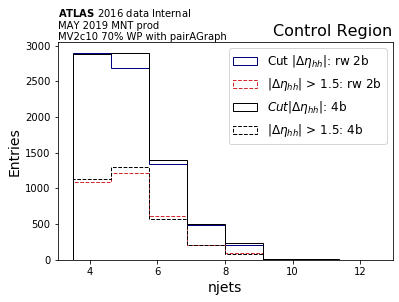

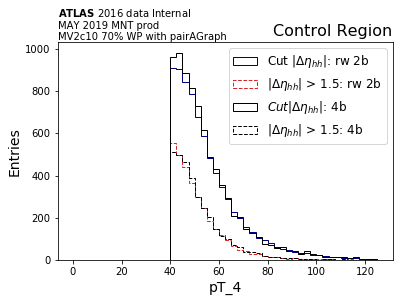

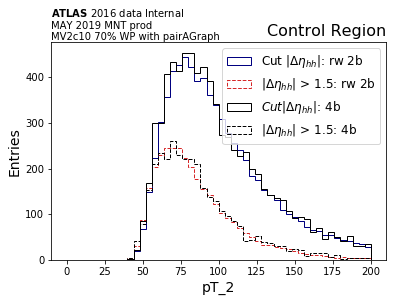

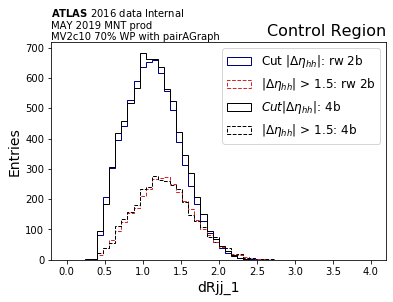

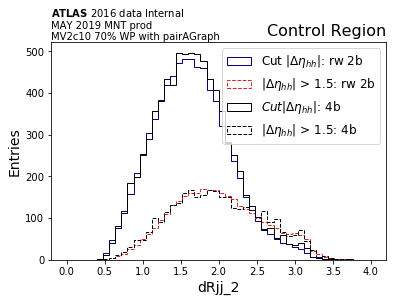

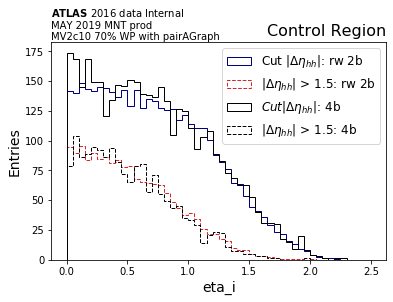

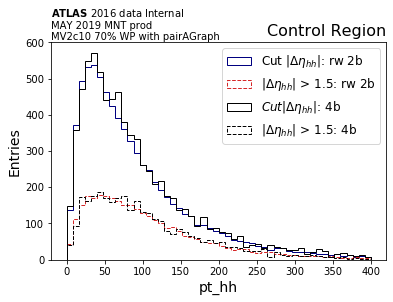

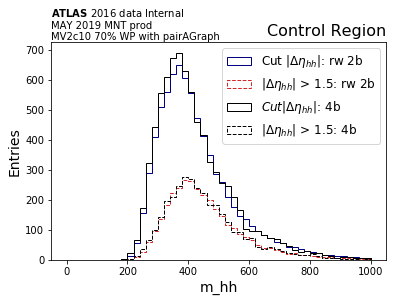

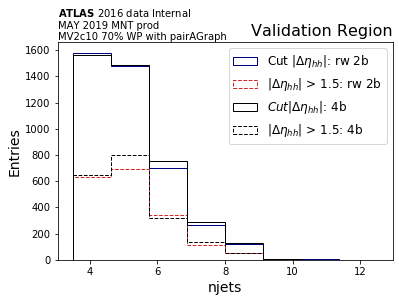

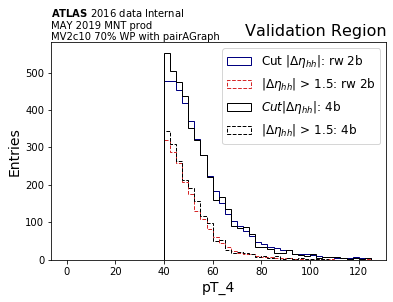

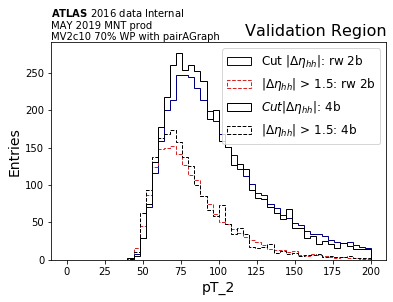

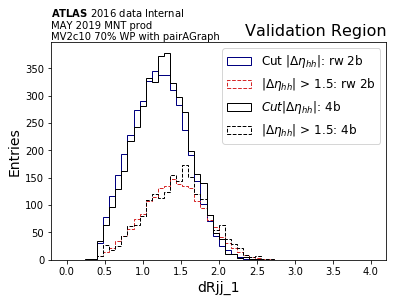

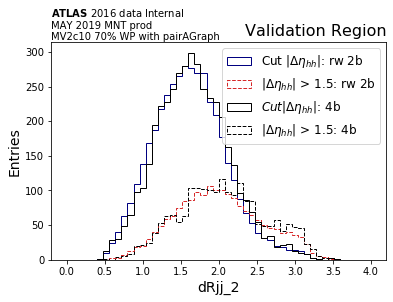

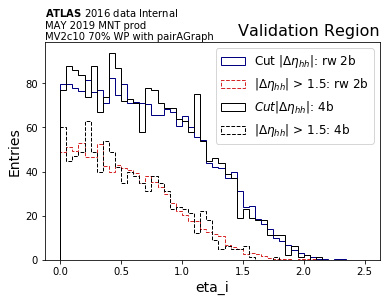

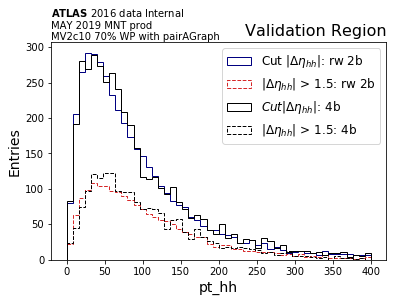

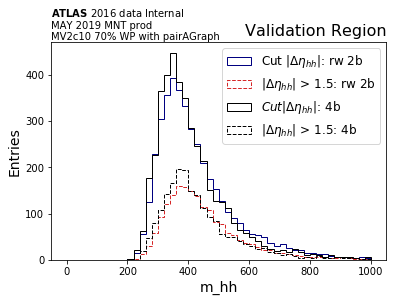

In [60]:
for region, title,tag in zip([2,1],['Control Region','Validation Region'],['CR','VR']):

    mask = df_pt.MDpT & (df_pt.kinematic_region==region)
    
    for c,n,r in zip(rw_vars,nBins,myRanges):

        plt.figure()
        plt.hist(df_pt.loc[(df_pt.ntag==2) & mask & df_pt.cut_deta_hh,c], 
                 n, r, color='navy',
                 histtype='step',label='Cut $|\Delta \eta_{hh}|$: rw 2b',
                 weights=df_pt.loc[(df_pt.ntag==2) & mask & df_pt.cut_deta_hh,'w_2b_afterPairing'])
        plt.hist(df_pt.loc[(df_pt.ntag==2) & mask & (~df_pt.cut_deta_hh),c], 
                 n, r, color='C3',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: rw 2b',
                 weights=df_pt.loc[(df_pt.ntag==2) & mask & (~df_pt.cut_deta_hh),'w_2b_afterPairing'])    

        plt.hist(df_pt.loc[(df_pt.ntag>=4) & mask & df_pt.cut_deta_hh,c],
                 n,r,color='k',
                 histtype='step',label='$Cut |\Delta \eta_{hh}|$: 4b')
        plt.hist(df_pt.loc[(df_pt.ntag>=4) & mask & (~df_pt.cut_deta_hh),c],
                 n,r,color='k',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: 4b')

        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12,loc='best')
        plt.title(title,loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

        #plt.savefig(f'figures/dl1r_77/rw_figs/{c}_cf_deta_hh_cut.pdf',bbox_inches='tight')
        plt.show()

In [61]:
175/125

1.4

**Thoughts:** Ok, so this PT idea really didn't work well, but I'm not sure why. (And I'm also not really 100% sure how to find out what the issue is.) 

- Do I just really need a background estimate with only 4b events for pairAGraph? If another student made a claim like this I'd be pretty skeptical.
- Maybe with the new pairing alg, I just need more variables in the reweighting? (Like Rui has shown that we can improve the reweighting a lot just by adding the jet $p_T$s.
- It seems like it's not just the # of events because I was able to train reweightings fine just using the ratio of 4b to 2b events w/ min $\Delta R_{jj}^{HC1}$ before.

**So it seems like the issue is that I still haven't corrected the input distributions enough.**

Is there a way I can rw on a 2b like variable? I think $n_{jets}$ was only way to do this, but I could also try summing up the quantiles, like Rafael was suggesting?

Or I could pass the quantiles for all of the jets, or the jet $p_T$s for all of the jets?


In [63]:
Db_cols

['ml_j0_Db', 'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db']

In [69]:
df_pt['sumQs'] = np.sum(df_pt[Db_cols].values,axis=-1)

In [70]:
?getNNweights

In [72]:
rw_cols_sumQs = rw_vars + ['sumQs']

In [83]:
modelName = f"NN_rw/{bkgSubDir}/xformer_train_SMNR_mc16ade/sumQs_PT_2b.h5"

getNNweights(df_pt, kinematic_region=2,epochs = 50, patience=10,
             sort_rw_cols=rw_cols_sumQs,
             train=False, key="w_2b_sumQs",modelName=modelName)

array([[1.14952154e-01],
       [6.99412994e-05],
       [1.22213601e-06],
       ...,
       [4.00193434e-09],
       [2.34848684e-07],
       [9.97141251e-06]], dtype=float32)

In [75]:
n,c = np.unique(df_pt['sumQs'],return_counts=True)

In [77]:
n,n.shape

(array([-7.5, -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. , -2.5, -2. ,
        -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,
         4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
         9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13.5]), (41,))

In [82]:
df_pt.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor',
       ...
       'period', 'deta_hh', 'pT_4_log', 'pT_2_log', 'dRjj_1_log', 'dRjj_2_log',
       'pt_hh_log', 'w_2b_afterPairing', 'sumQs', 'acc'],
      dtype='object', length=101)

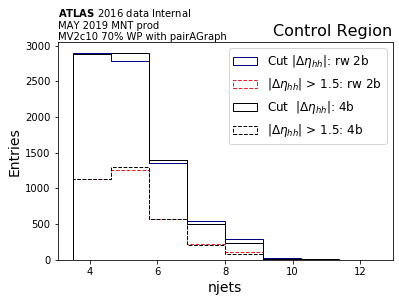

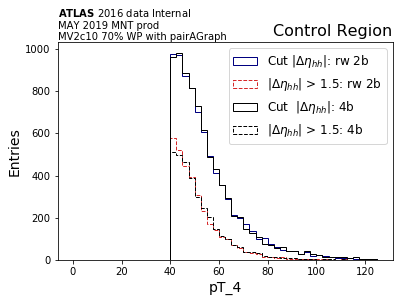

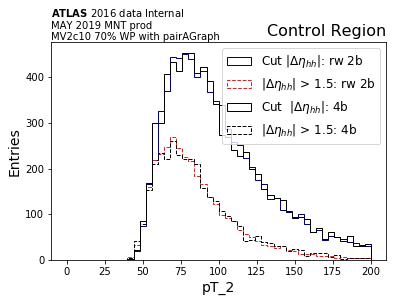

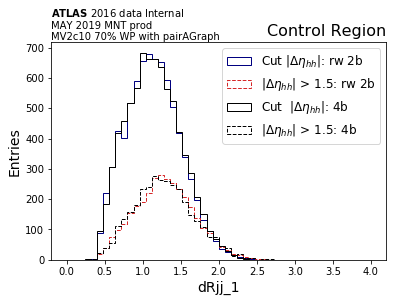

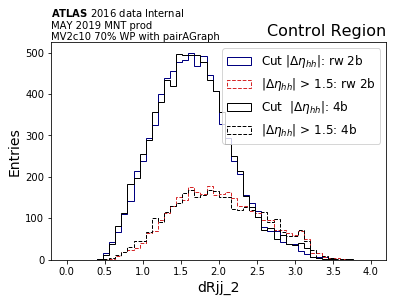

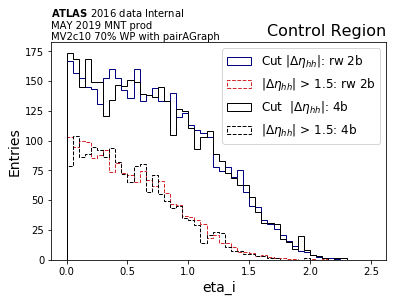

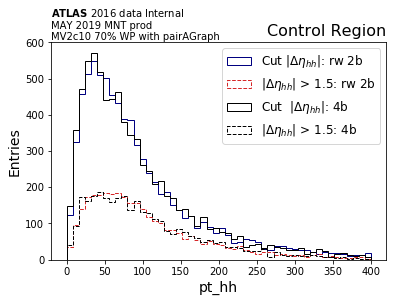

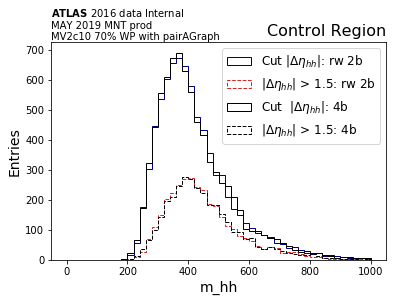

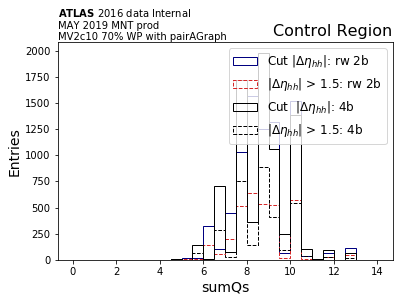

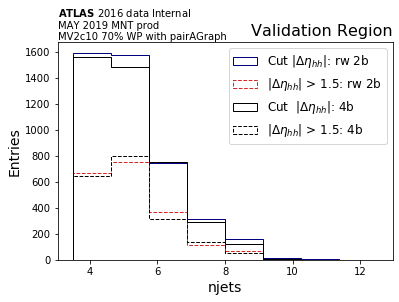

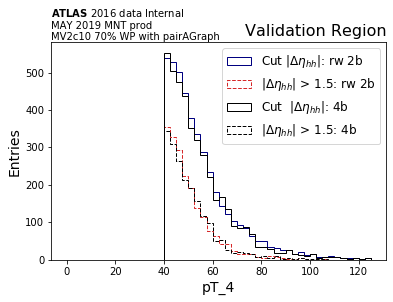

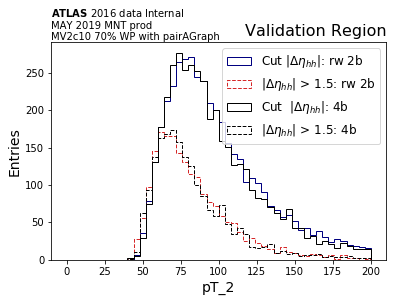

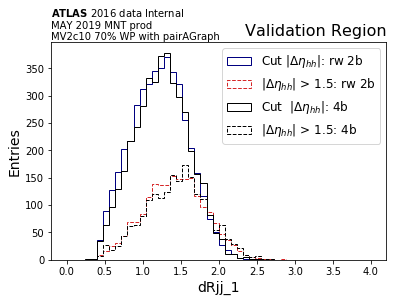

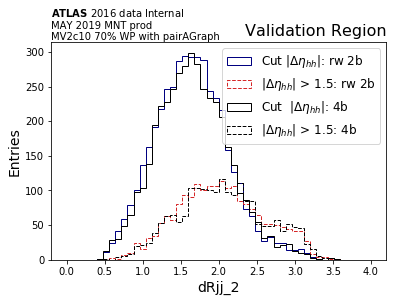

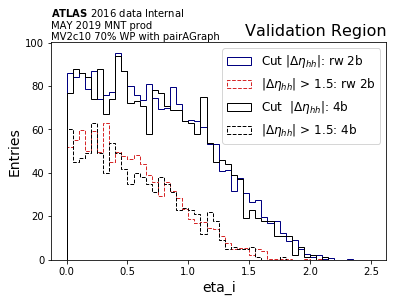

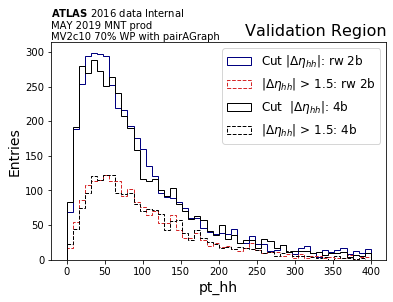

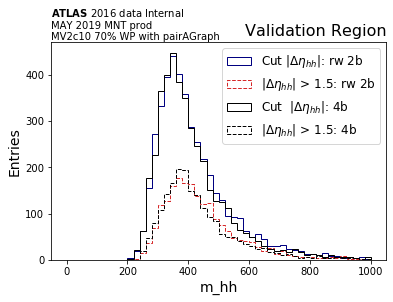

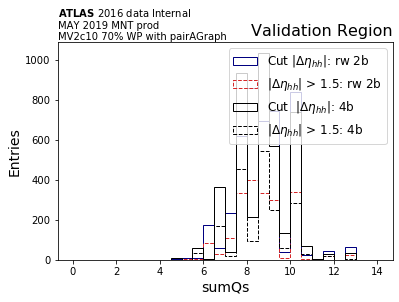

In [88]:
for region, title,tag in zip([2,1],['Control Region','Validation Region'],['CR','VR']):

    mask = df_pt.MDpT & (df_pt.kinematic_region==region)
    
    for c,n,r in zip(rw_cols_sumQs,nBins+[28],myRanges+[(0,14)]):

        plt.figure()
        plt.hist(df_pt.loc[(df_pt.ntag==2) & mask & df_pt.cut_deta_hh,c], 
                 n, r, color='navy',
                 histtype='step',label='Cut $|\Delta \eta_{hh}|$: rw 2b',
                 weights=df_pt.loc[(df_pt.ntag==2) & mask & df_pt.cut_deta_hh,'w_2b_sumQs'])
        plt.hist(df_pt.loc[(df_pt.ntag==2) & mask & (~df_pt.cut_deta_hh),c], 
                 n, r, color='C3',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: rw 2b',
                 weights=df_pt.loc[(df_pt.ntag==2) & mask & (~df_pt.cut_deta_hh),'w_2b_sumQs'])    

        plt.hist(df_pt.loc[(df_pt.ntag>=4) & mask & df_pt.cut_deta_hh,c],
                 n,r,color='k',
                 histtype='step',label='Cut  $|\Delta \eta_{hh}|$: 4b')
        plt.hist(df_pt.loc[(df_pt.ntag>=4) & mask & (~df_pt.cut_deta_hh),c],
                 n,r,color='k',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: 4b')

        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12,loc='best')
        plt.title(title,loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

        #plt.savefig(f'figures/dl1r_77/rw_figs/{c}_cf_deta_hh_cut.pdf',bbox_inches='tight')
        plt.show()

In [85]:
250/210

1.1904761904761905

Does this help?? Maybe a little bit, especially with the high $m_{hh}$ tails, but the modelling is still not great at low $m_{hh}$, it's off by *about* 20%. But, maybe the $p_T$ of the jets could be *quite* correlated with the jet $p_T$s at this low $m_{hh}$??

And Rui showed that this helped a lot for modelling the BDT output distribution, so I'm going to try this next!
 
Perhaps an especially indicative reason for this point is the fact that `pt_hh` is not getting rw enough (or maybe is getting rw too much... I'm not sure)? 


In [90]:
for c in df_pt.columns:
    print(c)

run_number
event_number
mc_sf
ntag
njets
kinematic_region
m_hh
pt_hh
X_wt
m_hh_cor
pT_h1
eta_h1
phi_h1
m_h1
dRjj_h1
pT_h2
eta_h2
phi_h2
m_h2
dRjj_h2
pT_2
pT_4
eta_i
dRjj_1
dRjj_2
cosThetaStar
cosTheta1
cosTheta2
Phi
Phi1
HT
MDR
MDpT
cut_deta_hh
cut_Xwt
pred_pair
GNNjets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_j1_E
ml_j2_E
ml_j3_E
ml_j4_E
ml_j0_Db
ml_j1_Db
ml_j2_Db
ml_j3_Db
ml_j4_Db
j0_pt
j1_pt
j2_pt
j3_pt
j4_pt
j0_eta
j1_eta
j2_eta
j3_eta
j4_eta
j0_phi
j1_phi
j2_phi
j3_phi
j4_phi
j0_E
j1_E
j2_E
j3_E
j4_E
j0_Db
j1_Db
j2_Db
j3_Db
j4_Db
idx_HC0_j0
idx_HC0_j1
idx_HC1_j0
idx_HC1_j1
period
deta_hh
pT_4_log
pT_2_log
dRjj_1_log
dRjj_2_log
pt_hh_log
w_2b_afterPairing
sumQs
acc
w_2b_sumQs


In [95]:
jet_pts = df_pt[[f'j{i}_pt' for i in range(nSelectedJets)]].values

In [98]:
jet_pts

array([[ 69.87620544, 278.81860352, 305.03051758,  73.74443817,
          0.        ],
       [ 56.96053241,  65.44519416,  75.33650693,  86.68691047,
         59.25591732],
       [114.79682239,  49.93500282,  47.62351149,  44.21398825,
          0.        ],
       ...,
       [105.01348877, 137.27560425,  43.4805336 ,  52.71444702,
          0.        ],
       [129.14672574, 130.17200098, 155.062668  ,  46.69256636,
          0.        ],
       [ 54.88319016,  44.28550339,  47.90822601,  44.30288315,
          0.        ]])

In [103]:
for hi in [0,1]:
    for ji in [0,1]:

        df_pt[f'pT_h{i}_j{i}'] = -1

        for i in range(nSelectedJets):
            mask = (df_pt[f'idx_HC{hi}_j{ji}']==i)
            df_pt.loc[mask,f'pT_h{hi}_j{ji}'] = jet_pts[mask,i]

I could also try *subtracting* 40 GeV before taking the log (compare distributions below).

Now train the model